# PART B- Customer Churn Prediction

## Data exploration and Preprocessing

Shape before cleaning: (7043, 21)
Target column: Churn


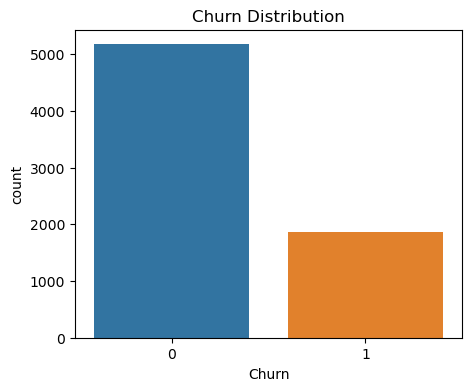

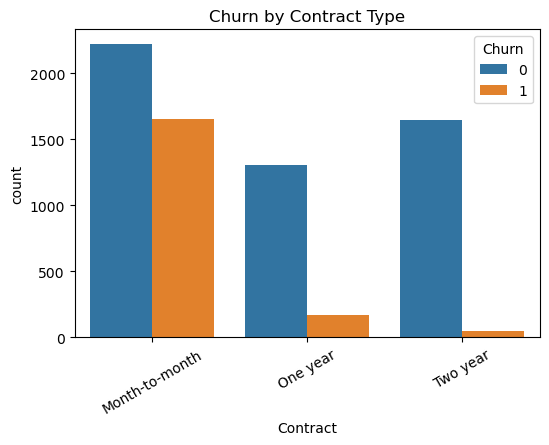

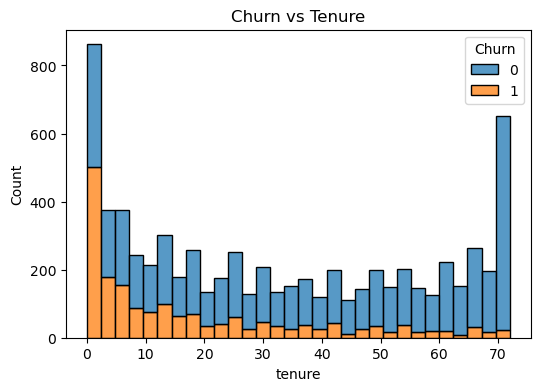

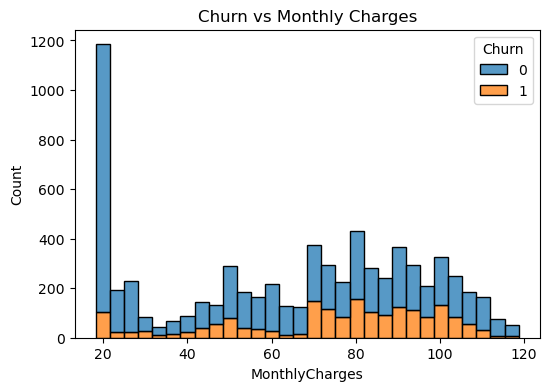

Numeric features: 6 | Categorical features: 15
Train size: (5634, 21) | Valid size: (704, 21) | Test size: (705, 21)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Customer_data - customer_data.csv")
print("Shape before cleaning:", df.shape)

# Drop duplicates
df = df.drop_duplicates()

# Drop columns with >60% missing values
df = df.drop(columns=[c for c in df.columns if df[c].isna().mean() > 0.6])

# Target column
target_col = [c for c in df.columns if "churn" in c.lower() or "exited" in c.lower()][0]
print("Target column:", target_col)

# Encode target
y = df[target_col].replace({"Yes":1,"No":0,"yes":1,"no":0})
X = df.drop(columns=[target_col])

# Drop ID-like columns
X = X.drop(columns=[c for c in X.columns if "id" in c.lower()])

# --- EDA ---
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Churn Distribution")
plt.show()

if "Contract" in X.columns or "contract" in X.columns:
    col = "Contract" if "Contract" in X.columns else "contract"
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=y, data=pd.concat([X,y], axis=1))
    plt.title("Churn by Contract Type")
    plt.xticks(rotation=30)
    plt.show()

if "tenure" in X.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(x="tenure", hue=y, data=pd.concat([X,y], axis=1), bins=30, multiple="stack")
    plt.title("Churn vs Tenure")
    plt.show()

if "MonthlyCharges" in X.columns or "monthly_charges" in X.columns:
    col = "MonthlyCharges" if "MonthlyCharges" in X.columns else "monthly_charges"
    plt.figure(figsize=(6,4))
    sns.histplot(x=col, hue=y, data=pd.concat([X,y], axis=1), bins=30, multiple="stack")
    plt.title("Churn vs Monthly Charges")
    plt.show()

# --- Feature Engineering Example ---
if "TotalCharges" in X.columns and "MonthlyCharges" in X.columns and "tenure" in X.columns:
    X["expected_total"] = X["MonthlyCharges"] * X["tenure"]
    X["charge_diff"] = pd.to_numeric(X["TotalCharges"], errors="coerce") - X["expected_total"]

# Identify numeric vs categorical
num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if c not in num_features]

print("Numeric features:", len(num_features), "| Categorical features:", len(cat_features))

# Train/Validation/Test Split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

print("Train size:", X_train.shape, "| Valid size:", X_valid.shape, "| Test size:", X_test.shape)

# Build Classification Models

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Preprocessing
num_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_trans, num_features),
    ("cat", cat_trans, cat_features)
])

# Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42)
}

# Train & Validate
results = {}
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    results[name] = {
        "Accuracy": accuracy_score(y_valid, preds),
        "Precision": precision_score(y_valid, preds, zero_division=0),
        "Recall": recall_score(y_valid, preds, zero_division=0),
        "F1": f1_score(y_valid, preds, zero_division=0)
    }

print("Validation Results:")
for m, vals in results.items():
    print(m, vals)

Validation Results:
LogisticRegression {'Accuracy': 0.7272727272727273, 'Precision': 0.49158249158249157, 'Recall': 0.7807486631016043, 'F1': 0.6033057851239669}
DecisionTree {'Accuracy': 0.7443181818181818, 'Precision': 0.512280701754386, 'Recall': 0.7807486631016043, 'F1': 0.6186440677966102}


# Model Evaluation on Test data

Best model selected: DecisionTree
Test Accuracy : 0.7546099290780142
Test Precision: 0.5275590551181102
Test Recall   : 0.7165775401069518
Test F1 Score : 0.6077097505668934


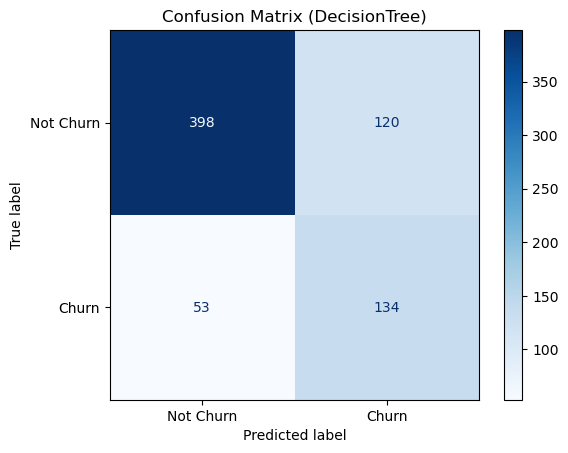


Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.88      0.77      0.82       518
       Churn       0.53      0.72      0.61       187

    accuracy                           0.75       705
   macro avg       0.71      0.74      0.71       705
weighted avg       0.79      0.75      0.76       705



In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Best model (highest F1)
best_model = max(results, key=lambda k: results[k]["F1"])
print("Best model selected:", best_model)

# Retrain on Train + Valid
final_pipe = Pipeline([("preprocess", preprocess), ("model", models[best_model])])
final_pipe.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

# Predict on Test
test_preds = final_pipe.predict(X_test)

# Metrics
acc = accuracy_score(y_test, test_preds)
prec = precision_score(y_test, test_preds, zero_division=0)
rec = recall_score(y_test, test_preds, zero_division=0)
f1 = f1_score(y_test, test_preds, zero_division=0)

print("Test Accuracy :", acc)
print("Test Precision:", prec)
print("Test Recall   :", rec)
print("Test F1 Score :", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix ({best_model})")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=["Not Churn", "Churn"]))

## Key Insights and Recommendations

**Key insights:**

- Short-tenure customers show higher churn risk.

- Increased monthly charges correlate with higher churn.

- Month-to-month plans churn more than yearly ones.

- Bundled services (internet, security, support) improve retention.

**Retention Recommendations:**

- Enhance onboarding and early engagement.

- Provide discounts or bundles for high-bill customers.

- Encourage long-term contracts with loyalty rewards.

- Promote value-added services to boost retention.

# PROJECT EXPLANATION VIDEO LINK:

" https://www.loom.com/share/4d4a68ba508841cd9b5c31b770ffe3e2"